In [1]:
#| default_exp GP_regression

In [2]:
#| hide
from nbdev.showdoc import *
import nbdev
from nbdev import nbdev_export

In [3]:
#| export
from ITS_LIVE_TOOL import datacube_tools, interactive, obj_setup, dataset_inspection

In [4]:
#| export
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, ExpSineSquared, RationalQuadratic, RBF
#from sklearn.model_selection import GridSearchCV
#from skopt import BayesSearchCV
#from skopt.space import Real, Categorical, Integer
#from sklearn.pipeline import Pipeline

In [5]:
#| hide 

data_map = interactive.Widget()

In [6]:
#| hide 

data_map.display()

In [7]:
#| hide 

glacier = obj_setup.create_glacier_from_click(data_map, 0)

In [8]:
#| hide 

glacier_point = obj_setup.create_glacier_point_from_click(data_map, 0, 'label')

original xy [76.36898340303199, 35.73397229126713] 4326 maps to datacube (623800.0526287752, 3955306.6088991463) EPSG:32643
original xy [76.36898340303199, 35.73397229126713] 4326 maps to datacube (623800.0526287752, 3955306.6088991463) EPSG:32643
subset and load at  57.82 seconds


In [9]:
#| hide 

ds = glacier_point.cube_around_point

Let's take a look at the image pair velocity time series for the point we specified. 

In [10]:
#| hide 

ds.median(dim=['x','y','time_numeric']).v

<xarray.DataArray 'v' ()>
array(104.)
Coordinates:
    mapping  int64 0

## Data filtering

In [11]:
print(len(ds.time_numeric))

24267


In [12]:
ds.v

<xarray.DataArray 'v' (time_numeric: 24267, y: 3, x: 3)>
array([[[140., 138., 139.],
        [137., 138., 139.],
        [127.,  nan,  nan]],

       [[ 93.,  93.,  93.],
        [ 91.,  96.,  94.],
        [ nan,  nan,  nan]],

       [[ 88.,  89.,  90.],
        [ 85.,  88.,  90.],
        [ 86.,  87.,  nan]],

       ...,

       [[ nan,  nan,  nan],
        [ nan,  nan,  nan],
        [ nan,  nan,  nan]],

       [[ nan,  nan,  nan],
        [ nan,  nan,  nan],
        [ nan,  nan,  nan]],

       [[ nan,  nan,  nan],
        [ nan,  nan,  nan],
        [ nan,  nan,  nan]]], dtype=float32)
Coordinates:
    img_separation  (time_numeric) float64 190.0 155.0 225.0 ... 481.0 88.0
    mid_date        (time_numeric) datetime64[ns] 2022-05-27T05:37:39.2202209...
  * x               (x) float64 6.237e+05 6.238e+05 6.239e+05
  * y               (y) float64 3.955e+06 3.955e+06 3.955e+06
  * time_numeric    (time_numeric) float64 2.022e+03 2.022e+03 ... 2.014e+03
    mapping         int64 0
Attributes:
    description:    velocity magnitude
    grid_mapping:   mapping
    standard_name:  land_ice_surface_velocity
    units:          meter/year

In [13]:
ds_long = ds.where(ds.img_separation >= 365, drop=True)

In [14]:
ds_long.v

<xarray.DataArray 'v' (time_numeric: 5525, y: 3, x: 3)>
array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[94., 94., 94.],
        [93., 93., 93.],
        [89., 89., nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]], dtype=float32)
Coordinates:
    img_separation  (time_numeric) float64 456.0 417.0 371.0 ... 408.0 481.0
    mid_date        (time_numeric) datetime64[ns] 2022-03-10T17:38:00.2107258...
  * x               (x) float64 6.237e+05 6.238e+05 6.239e+05
  * y               (y) float64 3.955e+06 3.955e+06 3.955e+06
  * time_numeric    (time_numeric) float64 2.022e+03 2.014e+03 ... 2.015e+03
    mapping         int64 0
Attributes:
    description:    velocity magnitude
    grid_mapping:   mapping
    standard_name:  land_ice_surface_velocity
    units:          meter/year

In [15]:
ds_sub = dataset_inspection.trim_by_baseline(ds)

102.0
5


In [16]:
len(ds_sub.time_numeric)

18400

In [23]:
#| hide 

df = ds_sub[['v','v_error','img1_numeric','img2_numeric']].to_dataframe().reset_index()

In [24]:
df

,time_numeric,y,x,v,v_error,img1_numeric,img2_numeric,img_separation,mid_date,mapping
0,1990.471233,3955387.5,623692.5,99.0,6.0,1989.879452,1991.063014,432.0,1990-06-21 04:51:31.574145024,0
1,1990.471233,3955387.5,623812.5,100.0,6.0,1989.879452,1991.063014,432.0,1990-06-21 04:51:31.574145024,0
2,1990.471233,3955387.5,623932.5,100.0,6.0,1989.879452,1991.063014,432.0,1990-06-21 04:51:31.574145024,0
3,1990.471233,3955267.5,623692.5,99.0,6.0,1989.879452,1991.063014,432.0,1990-06-21 04:51:31.574145024,0
4,1990.471233,3955267.5,623812.5,100.0,6.0,1989.879452,1991.063014,432.0,1990-06-21 04:51:31.574145024,0
...,...,...,...,...,...,...,...,...,...,...
165595,2022.909589,3955267.5,623812.5,NaN,NaN,2022.813699,2023.005479,71.0,2022-11-28 05:40:51.221024000,0
165596,2022.909589,3955267.5,623932.5,NaN,NaN,2022.813699,2023.005479,71.0,2022-11-28 05:40:51.221024000,0
165597,2022.909589,3955147.5,623692.5,NaN,NaN,2022.813699,2023.005479,71.0,2022-11-28 05:40:51.221024000,0
165598,2022.909589,3955147.5,623812.5,NaN,NaN,2022.813699,2023.005479,71.0,2022-11-28 05:40:51.221024000,0


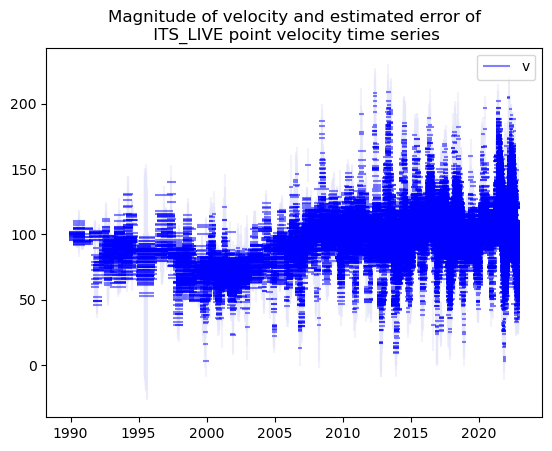

In [29]:
#| hide 

fig, ax = plt.subplots()

ax.errorbar(y=df['v'], yerr = df['v_error'], x = df['time_numeric'], color='lavender', linestyle='None', alpha=0.5)
ax.hlines(xmin = df['img1_numeric'], xmax = df['img2_numeric'],y = df['v'], color='blue', label='v',alpha=0.5)
#ax.set_ylim(0,800)
ax.legend()
ax.set_title('Magnitude of velocity and estimated error of\n ITS_LIVE point velocity time series');

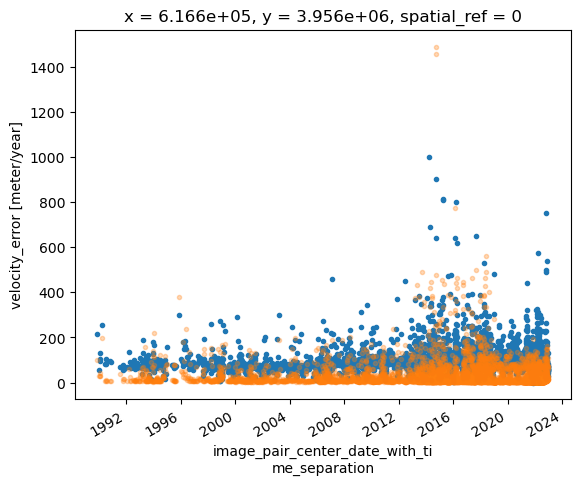

In [ ]:
#| hide 

fig, ax = plt.subplots()
glacier_point.datacube_point.v.plot(ax=ax, linestyle='None', marker='o', markersize=3);
glacier_point.datacube_point.v_error.plot(ax=ax, linestyle='None', marker='o', alpha = 0.3, markersize=3);

This was just for one pixel. `Glacier_Point` also contains a 3x3 pixel cube surrounding the specified point to account for potential outlier estimates.

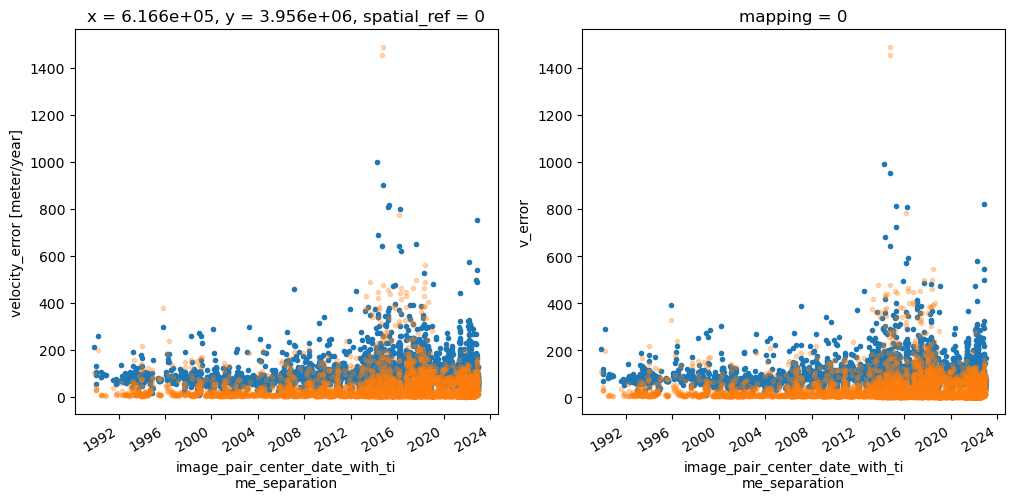

In [ ]:
#| hide 

fig, axs = plt.subplots(ncols=2, figsize=(12,5))
glacier_point.cube_around_point.v.median(dim=['x','y']).plot(ax=axs[1], linestyle='None', marker='o', markersize=3);
glacier_point.cube_around_point.v_error.median(dim=['x','y']).plot(ax=axs[1], linestyle='None', marker='o', alpha = 0.3, markersize=3);

glacier_point.datacube_point.v.plot(ax=axs[0], linestyle='None', marker='o', markersize=3);
glacier_point.datacube_point.v_error.plot(ax=axs[0], linestyle='None', marker='o', alpha = 0.3, markersize=3);

This comparison shows us that the trends we see in the single pixel plot are not too different from the pixels surrounding it. Good to know! 

Taking a look at this time series, we can see that there is interesting variability but also a fair amount of noise. This is where the regression methods become useful. 

Now we'll look at setting up the Gaussian Process model.

In [30]:
#| hide

point_ls = [glacier_point]

In [35]:
#| export
def prepare_ds(point_obj):

    '''note: i think this should be in its own notebook because its a different procss/step
       keeping here for now just to get an example going
       '''
    ds = point_obj.cube_around_point

    ds_sub = ds.where(ds.img_separation >= 60., drop=True)

    return ds, ds_sub

In [31]:
#| export
from sklearn.preprocessing import MinMaxScaler
import torch

class ModelInputs():
    '''this is a class to store model inputs for GP Regression. it is intended to store data for an individual temporal baseline category.
    '''
    def __init__(self, label, df, col, cutoffs):

        self.label = label
        self.df = df
        self.col = col
        self.cutoffs = cutoffs
        self.df_subset = self._filter_baselines()
        self.t_train, self.y_train, self.t_test, self.noise, self.scaled_y_train = self._organize_training_data()

    def _filter_baselines(self):
        df = self.df
        cutoffs = self.cutoffs
        df = df.dropna(subset=self.col)
        df_sub = df.loc[(df['img_separation'] >= cutoffs[0]) & (df['img_separation'] < cutoffs[1])]
        return df_sub

    def _organize_training_data(self):

        scaler = MinMaxScaler()
    
        t_train_np = self.df_subset.time_numeric.values
        y_train_np = self.df_subset[self.col].values
        model = scaler.fit(y_train_np.reshape(-1,1))
        scaled_y_train_np = model.transform(y_train_np.reshape(-1,1)).ravel()
    
        t_train_tensor = torch.Tensor(t_train_np)
        y_train_tensor = torch.Tensor(y_train_np)
        scaled_y_train_tensor = torch.Tensor(scaled_y_train_np)
    
        t_test_np = np.linspace(t_train_np.min(), t_train_np.max(), len(t_train_np))
        t_test_tensor = torch.Tensor(t_test_np)

        noise_tensor = torch.Tensor(self.df_subset['spatial_median_v_err'].values)
    
        
        return t_train_tensor, y_train_tensor, t_test_tensor, noise_tensor, scaled_y_train_tensor

In [39]:
#| export
def point_to_model_input(point_ls_obj, tb_category):

    point_ds, point_ds_sub = prepare_ds(point_ls_obj)

    #point_ds_sub = swap_time_dim(point_ds_sub)
    ds_new = point_ds_sub
    #ds_new = swap_time_dim(point_ds_sub)
    ds_new['spatial_median_v'] = (('time_numeric'), ds_new.v.median(dim=['x','y']).data)
    ds_new['spatial_median_v_err'] = (('time_numeric'), ds_new.v_error.median(dim=['x','y']).data)
    df = ds_new[['mid_date','spatial_median_v','time_numeric','img_separation','spatial_median_v_err']].to_dataframe().reset_index().dropna(subset='spatial_median_v')

    mod_input = ModelInputs(point_ls_obj.label, df, 'spatial_median_v', tb_category)

    return mod_input

In [40]:
#| export 
class SKLearnModelPreds():
    def __init__(self, inputs, kernel):
        self.inputs = inputs
        self.kernel = kernel
        #self.priors = priors
        self.t_train = self.inputs.t_train.numpy().reshape(-1,1)
        self.y_train = self.inputs.y_train.numpy().reshape(-1,1)
        self.t_test = self.inputs.t_test.numpy().reshape(-1,1)
        self.gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, optimizer='fmin_l_bfgs_b')
        self.y_pred, self.sigma, self.rmse = self.run_model()

    def run_model(self):

        self.gp.fit(self.t_train, self.y_train)
        y_pred, sigma = self.gp.predict(self.t_test, return_std=True)
        rmse = np.sqrt(((y_pred - self.y_train)**2).mean())
        return y_pred, sigma, rmse

In [41]:
#| export
mod_input_ls = []

for j in range(len(point_ls)):
    
    mod_input = point_to_model_input(point_ls[j], [0,600])
    mod_input_ls.append(mod_input)

In [ ]:
#| export
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, ExpSineSquared, RBF
from sklearn.model_selection import GridSearchCV

kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0)) + Matern(length_scale=1.5, length_scale_bounds=(0.0, 10.0), nu = 1.5) + ExpSineSquared(length_scale=1, periodicity=1, length_scale_bounds = (0,10), periodicity_bounds=(1e-3, 10.0)) + WhiteKernel(noise_level=2., noise_level_bounds = (1e-6,1e3))

mod_output_ls = []
for i in range(len(point_ls)):
    mod_output = SKLearnModelPreds(mod_input_ls[i], kernel)
    mod_output_ls.append(mod_output)

In [ ]:
#| hide 
%matplotlib widget

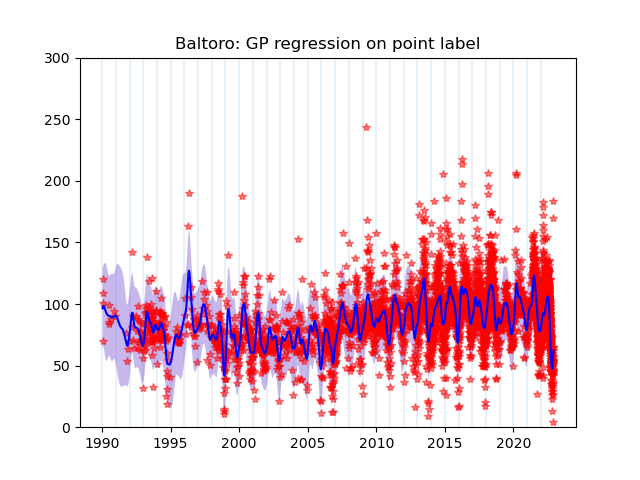

In [ ]:
#| hide
fig, ax = plt.subplots()

ax.plot(mod_output_ls[0].t_train, mod_output_ls[0].y_train, 'r*', alpha = 0.5)
ax.plot(mod_output_ls[0].t_test, mod_output_ls[0].y_pred, c='blue')
ax.fill_between(mod_output_ls[0].t_test.ravel(),
                          mod_output_ls[0].y_pred + 1.96 * mod_output_ls[0].sigma,
                          mod_output_ls[0].y_pred - 1.96 * mod_output_ls[0].sigma,
                          facecolor='mediumpurple',alpha = 0.5)
x_ls = np.arange(1990, 2023, 1)
    

ax.set_ylim(0,300)
ax.set_title(f'Baltoro: GP regression on point {point_ls[0].label}')
    #axd[ax].legend(loc='upper center', ncols=3, bbox_to_anchor=(0.95, 1.05))
for x in x_ls:
    ax.axvline(x = x, alpha=0.1);
    

In [ ]:
# somewhere in this notebook a time sereis plot with horizontal bars corresponidng to temporal baseline should be added to convey different types of ice movement meaersurements

In [ ]:
#| hide 

import nbdev.showdoc as showdoc

In [ ]:
#| hide 

showdoc.show_doc(obj_setup.Glacier_Point.point_to_gdf)

---

[source](https://github.com/e-marshall/ITS_LIVE_TOOL/blob/main/ITS_LIVE_TOOL/obj_setup.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Glacier_Point.point_to_gdf

>      Glacier_Point.point_to_gdf ()

In [ ]:
#| hide 

showdoc.show_doc(obj_setup.create_glacier_from_click)

---

[source](https://github.com/e-marshall/ITS_LIVE_TOOL/blob/main/ITS_LIVE_TOOL/obj_setup.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### create_glacier_from_click

>      create_glacier_from_click (w_obj, i)

this function takes clicked information (from a single click, not all clicked points) and returns a `Glacier` type object